#  The Annotated Transformer with Tensorflow

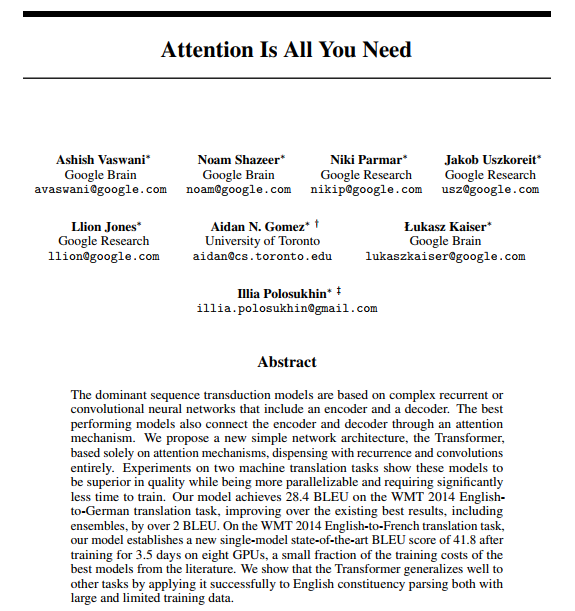

The Transformer from ["Attention is All You Need"](https://arxiv.org/abs/1706.03762) has been on a lot of people's minds over the last year. Besides producing major improvements in translation quality, it provides a new architecture for many other NLP tasks. The paper itself is very clearly written, but the conventional wisdom has been that it is quite difficult to implement correctly. 

In this post I present an "annotated" version of the paper in the form of a line-by-line implementation. I have reordered and deleted some sections from the original paper and added comments throughout. This document itself is a working notebook, and should be a completely usable implementation. In total there are 400 lines of library code which can process 27,000 tokens per second on 4 GPUs. 

To follow along you will first need to install [PyTorch](http://pytorch.org/). The complete notebook is also available on [github](https://github.com/harvardnlp/annotated-transformer) or on Google [Colab](https://drive.google.com/file/d/1xQXSv6mtAOLXxEMi8RvaW8TW-7bvYBDF/view?usp=sharing). 

Note this is merely a starting point for researchers and interested developers. The code here is based heavily on our [OpenNMT](http://opennmt.net) packages. (If helpful feel free to [cite](#conclusion).) For other full-sevice implementations of the model check-out [Tensor2Tensor](https://github.com/tensorflow/tensor2tensor) (tensorflow) and [Sockeye](https://github.com/awslabs/sockeye) (mxnet).

- Alexander Rush ([@harvardnlp](https://twitter.com/harvardnlp) or srush@seas.harvard.edu)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

Table of Contents


* Table of Contents                               
{:toc} 

# Background

The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU, ByteNet and ConvS2S, all of which use convolutional neural networks as basic building block, computing hidden representations in parallel for all input and output positions. In these models, the number of operations required to relate signals from two arbitrary input or output positions grows in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes it more difficult to learn dependencies between distant positions. In the Transformer this is reduced to a constant number of operations, albeit at the cost of reduced effective resolution due to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention.

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations. End-to-end memory networks are based on a recurrent attention mechanism instead of sequencealigned recurrence and have been shown to perform well on simple-language question answering and
language modeling tasks.

To the best of our knowledge, however, the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence aligned RNNs or convolution. 

# Model Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure [(cite)](https://arxiv.org/abs/1409.0473). Here, the encoder maps an input sequence of symbol representations $(x_1, ..., x_n)$ to a sequence of continuous representations $\mathbf{z} = (z_1, ..., z_n)$. Given $\mathbf{z}$, the decoder then generates an output sequence $(y_1,...,y_m)$ of symbols one element at a time. At each step the model is auto-regressive [(cite)](https://arxiv.org/abs/1308.0850), consuming the previously generated symbols as additional input when generating the next. 

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1, respectively.

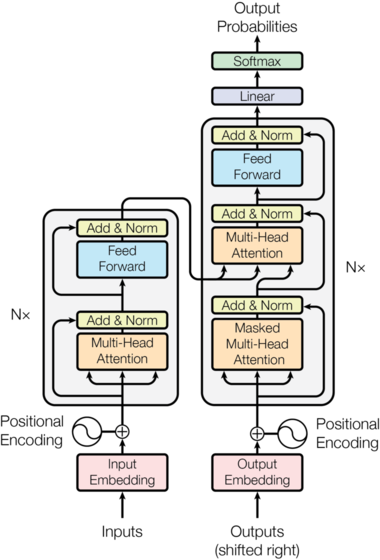

## Encoder and Decoder Stacks   

### Encoder

The encoder is composed of a stack of $N=6$ identical layers. 

In [262]:
def encoder(x, mask, size, drop_rate, N=6):
    #x: (b, V-1, d_model);
    #mask: (b,1, V-1);
    for i in range(N):
        x = encoder_layer(x, mask, size, drop_rate)
    return layer_norm(x, size)

In [265]:
def encoder_layer(x, mask, size, drop_rate):
    #x: (b, V-1, d_model);
    #mask: (b,1, V-1);
    norm1 = layer_norm(x, size)
    
    z, attn = multi_head_attn(norm1, norm1, norm1, mask, size, drop_rate, h=8)
    slc1 = x + tf.layers.dropout(z, rate=drop_rate)
    
    norm2 = layer_norm(slc1, size)
    ff = feed_forward(norm2, drop_rate, size)
    slc2 = slc1 + tf.layers.dropout(ff, rate=drop_rate)
    
    return slc2

We employ a residual connection [(cite)](https://arxiv.org/abs/1512.03385) around each of the two sub-layers, followed by layer normalization [(cite)](https://arxiv.org/abs/1607.06450).

In [263]:
def layer_norm(x, size, eps=1e-6):
    mean = tf.reduce_mean(x, axis=-1, keepdims=True)
    std = tf.math.reduce_std(x, axis=-1, keepdims=True)
    z = (x - mean) / (std + eps)
    return tf.layers.dense(z, units=size, kernel_initializer='ones', bias_initializer='zeros')

That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.  We apply dropout [(cite)](http://jmlr.org/papers/v15/srivastava14a.html) to the output of each sub-layer, before it is added to the sub-layer input and normalized.  

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.  

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

### Decoder

The decoder is also composed of a stack of $N=6$ identical layers.  


In [267]:
def decoder(x, memory, src_mask, tgt_mask, size, drop_rate, N=6):
    #x: (b, V-2, d_model);
    #mask: (b,V-2, V-2);
    for i in range(N):
        x = decoder_layer(x, memory, src_mask, tgt_mask, size, drop_rate)
    return layer_norm(x, size)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.

In [266]:
def decoder_layer(x, memory, src_mask, tgt_mask, size, drop_rate):
    #x: (b, V-2, d_model);
    #mask: (b,V-2, V-2);
    m = memory
    
    norm1 = layer_norm(x, size)
    zt, attnt = multi_head_attn(norm1, norm1, norm1, tgt_mask, size, drop_rate,h=8)
    slc1 = x + tf.layers.dropout(zt, rate=drop_rate)
    
    norm2 = layer_norm(slc1, size)
    zs, attns = multi_head_attn(norm2, m, m, src_mask, size, drop_rate, h=8)
    slc2 = slc1+ tf.layers.dropout(zs, rate=drop_rate)
    
    norm3 = layer_norm(slc2, size)
    ff = feed_forward(norm3, drop_rate, size)
    slc3 = slc2 + tf.layers.dropout(ff, rate=drop_rate)
    
    return slc3

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions.  This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.

In [268]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (size, size) #(V-2 V-2)
    row = tf.range(size) #(V-2)
    mat = tf.reshape(tf.tile(row, multiples=[size]), [size, size]) #(V-2 V-2)
    mat = mat - tf.transpose(mat) #(V-2 V-2)
    sm = tf.to_float(tf.greater(mat, 0)) #(V-2 V-2)
    return tf.expand_dims(tf.equal(sm, 0),0) #(1, V-2 V-2)

> Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.

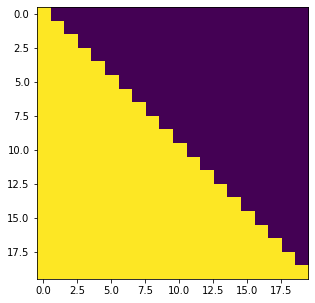

In [271]:
with tf.Session() as sess:
    sm = subsequent_mask(20)
    plt.figure(figsize=(5,5))
    plt.imshow(sess.run(sm)[0])


### Attention                                                                                                                                                                                                                                                                             
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.                                                                                                                                                                                                                                                                                   

We call our particular attention "Scaled Dot-Product Attention".   The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$.  We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.                                                                                                                                                                                                                                  
                                                                                                                                                                     

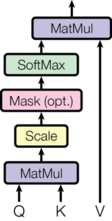


In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:                      
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$   

In [273]:
def attention(query, key, value, drop_rate, mask=None ):
    "Compute 'Scaled Dot Product Attention'"
    #query, key, value: (b, h, V-1, d_model/h)
    if mask is not None:
        mask = tf.expand_dims(mask, 1) #encoder: (b,1,1, V-1); decoder: (b,1,V-2, V-2)
    d_k = tf.to_float(tf.shape(query)[-1])
    scores = tf.divide(tf.matmul(query, tf.transpose(key, [0,1,3,2])), tf.sqrt(d_k)) #encoder: (b,h,V-1,V-1); decoder: (b,h,V-2,V-2) 
    
    if mask is not None:
        mask_dim1 = tf.shape(mask)[1] #encoder: (1); decoder: (1)
        mask_dim2 = tf.shape(mask)[2] #encoder: (1); decoder: (V-2)
        
        scores_dim1 = tf.shape(scores)[1] #(h)
        scores_dim2 = tf.shape(scores)[2] #encoder: V-1; decoder: V-2
        mask = tf.to_float(tf.tile(mask, [1, tf.to_int32(scores_dim1/mask_dim1), tf.to_int32(scores_dim2/mask_dim2), 1])) #mask.shape = scores.shape
        scores = tf.multiply(tf.to_float(tf.not_equal(mask, 0)), scores) + -1e9*tf.to_float(tf.equal(mask, 0)) #put 1e-9 whereever mask=0
    p_attn = tf.nn.softmax(scores, axis=-1) #scores.shape
    p_attn = tf.layers.dropout(p_attn, rate=drop_rate) #scores.shape
    return tf.matmul(p_attn, value), p_attn  #(encoder: (b, h, V-1, d_model/h); decoder: (b, h, V-2, d_model/h)) , scores.shape

The two most commonly used attention functions are additive attention [(cite)](https://arxiv.org/abs/1409.0473), and dot-product (multiplicative) attention.  Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer.  While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.                                                                                             

                                                                        
While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$ [(cite)](https://arxiv.org/abs/1703.03906). We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients  (To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean $0$ and variance $1$.  Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance $d_k$.). To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.          

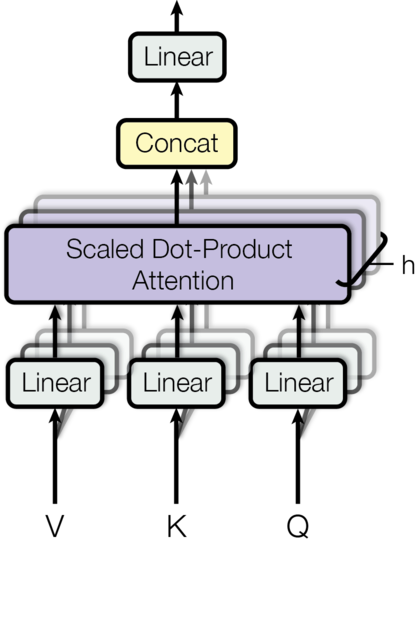

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.                                            
$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$                                                                                                                 

Where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.                                                                                                                                                                                             In this work we employ $h=8$ parallel attention layers, or heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality. 

In [274]:
def multi_head_attn(q, k, v, mask, size, drop_rate, h=8):
    #k,v,q: (b, V-1, d_model)
    #size= d_model
    #if decoder: V-1 = V-2
    
    query = linear(q, size, size, True) #(b, V-1, d_model)
    key = linear(k, size, size, True) #(b, V-1, d_model)
    value = linear(v, size, size, True) #(b, V-1, d_model)
    d_k = size // h
    bs = tf.shape(query)[0]
    query = tf.reshape(query, [bs, h, -1, d_k]) #(b, h, V-1, d_model/h)
    key = tf.reshape(key, [bs, h, -1, d_k]) #(b, h, V-1, d_model/h)
    value = tf.reshape(value, [bs, h, -1, d_k]) #(b, h, V-1, d_model/h)
    x, attn = attention(query, key, value, drop_rate, mask )
    x = tf.reshape(x, [bs, -1, h * d_k])
    return linear(x, d_model, d_model, True), attn

In [280]:
def linear(x, dim_1, dim_2, is_3d=True):
    #x: (None, dim_1)
    initializer = tf.contrib.layers.xavier_initializer()
    if is_3d:
        w = tf.Variable(initializer([1,dim_1, dim_2]))
        b = tf.Variable(initializer([1, 1, dim_2]))
        f = tf.to_int32(tf.shape(x)[0])
        w = tf.tile(w, [f,1,1])
        b = tf.tile(b, [f,1,1])
        return tf.matmul(x, w)+b
    else:
        w = tf.Variable(initializer([dim_1, dim_2]))
        b = tf.Variable(initializer([1, dim_2]))
        return tf.matmul(x, w)+b

### Applications of Attention in our Model                                                                                                                                                      
The Transformer uses multi-head attention in three different ways:                                                        
1) In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder.   This allows every position in the decoder to attend over all positions in the input sequence.  This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as [(cite)](https://arxiv.org/abs/1609.08144).    


2) The encoder contains self-attention layers.  In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder.   Each position in the encoder can attend to all positions in the previous layer of the encoder.                                                   


3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position.  We need to prevent leftward information flow in the decoder to preserve the auto-regressive property.  We implement this inside of scaled dot-product attention by masking out (setting to $-\infty$) all values in the input of the softmax which correspond to illegal connections.                                                                                                                                                                                                                                                      

## Position-wise Feed-Forward Networks                                                                                                                                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically.  This consists of two linear transformations with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                        
While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1.  The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has dimensionality $d_{ff}=2048$. 

In [278]:
def feed_forward(x, drop_rate, size, d_ff=2048):
    l1 = linear(x, size, d_ff, True)
    re = tf.nn.relu(l1)
    dr = tf.layers.dropout(re, rate=drop_rate)
    l2 = linear(dr, d_ff, size, True)
    return l2

## Embeddings and Softmax                                                                                                                                                                                                                                                                                           
Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{\text{model}}$.  We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities.  In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [(cite)](https://arxiv.org/abs/1608.05859). In the embedding layers, we multiply those weights by $\sqrt{d_{\text{model}}}$.                                                                                                                                 

In [279]:
def embeddings(x, vocab, size):
    #x: (b, V-1)
    initializer =  tf.contrib.layers.xavier_initializer()
    lut = tf.Variable(initializer([vocab, size])) #(V, d_model)
    return tf.gather(lut, x) * math.sqrt(size) #(b, V-1, d_model)

## Positional Encoding                                                                                                                             
Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.  To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.  The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.   There are many choices of positional encodings, learned and fixed [(cite)](https://arxiv.org/pdf/1705.03122.pdf). 

In this work, we use sine and cosine functions of different frequencies:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$                                                                                                                                                                                                                                                        
where $pos$ is the position and $i$ is the dimension.  That is, each dimension of the positional encoding corresponds to a sinusoid.  The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.  We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$. 

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.  For the base model, we use a rate of $P_{drop}=0.1$. 
                                                                                                                                                                                                                                                    


In [276]:
def positional_emb(x, d_model, drop_rate, max_len=5000):
    position = tf.to_float(tf.range(max_len))
    position = tf.expand_dims(position, 1)
    div_term = tf.exp(tf.multiply(tf.to_float(tf.range(0, d_model, 2)),-(math.log(10000.0) / d_model)))
    div_term = tf.expand_dims(div_term,0)
    even = tf.transpose(tf.sin(position * div_term)) # (d_model/2,max_len) 
    odd = tf.transpose(tf.cos(position * div_term))
    even_odd = tf.transpose(tf.stack([even, odd], axis=2), [0,2,1])
    
    ind_1 = tf.range(tf.to_int32(d_model/2))
    ind_1 = tf.stack([ind_1, ind_1], axis=1)
    ind_1 = tf.reshape(ind_1, [-1]) 
    ind_2 = tf.tile([0,1,0,1],[tf.to_int32(d_model/4)])
    ind_12 = tf.stack([ind_1, ind_2], axis=1)
    pe =  tf.expand_dims(tf.transpose(tf.gather_nd(even_odd, ind_12)), axis=0)
    pe = tf.transpose(pe, [1,0,2])
    x = x+ tf.transpose(tf.gather(pe, tf.range(tf.shape(x)[1])), [1,0,2])
    return tf.nn.dropout(x, rate=drop_rate)

> Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension. 

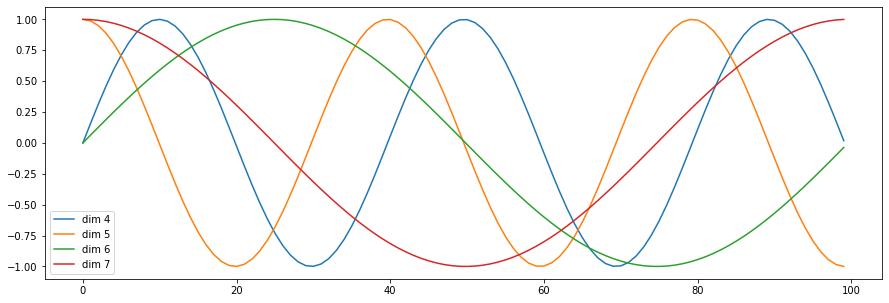

In [277]:
plt.figure(figsize=(15, 5))
y = positional_emb(tf.zeros([1, 100, 20]), 20,0)
with tf.Session() as sess:
    y = sess.run(y)
    plt.plot(np.arange(100), y[0, :, 4:8])
    plt.legend(["dim %d"%p for p in [4,5,6,7]])

We also experimented with using learned positional embeddings [(cite)](https://arxiv.org/pdf/1705.03122.pdf) instead, and found that the two versions produced nearly identical results.  We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.    

In [4]:
def sequential(x, vocab, size, drop_rate):
    emb = embeddings(x, vocab, size)
#     return emb
    return positional_emb(emb, size, drop_rate)

# Batches and Masking


In [ ]:
def make_std_mask(tgt, pad):
    "Create a mask to hide padding and future words."
    #tgt: (b, V-2)
    #pad: ()
    tgt_mask = tf.expand_dims(tf.not_equal(tgt, pad), axis=-2)  #(b, 1, V-2)
    sm = subsequent_mask(tf.shape(tgt)[-1])   #(1, V-2 V-2)
    tgt_mask_tile = tf.tile(tgt_mask, [1,tf.shape(sm)[1], 1])  #(b, V-2, V-2)
    sm_tile = tf.tile(sm, [tf.shape(tgt_mask)[0], 1, 1]) #(b, V-2, V-2)
    tgt_mask = tf.logical_and(tgt_mask_tile, sm_tile) #(b, V-2, V-2)
    return tgt_mask #(b, V-2, V-2)

In [4]:
def batch(src, trg=None, pad=0):
    #src : #(b, V-1)
    #trg:  #(b, V-1)
    src_mask = tf.expand_dims(tf.not_equal(src, pad), axis=-2) #(b,1, V-1)
    trg_new = trg[:, :-1] #(b, V-2)
    trg_y = trg[:, 1:]  #(b, V-2)
    trg_mask = make_std_mask(trg_new, pad) #(b, V-2, V-2)
    ntokens = tf.reduce_sum(tf.to_float(tf.not_equal(trg_y, pad))) #()
    return src, trg_new, src_mask, trg_mask, trg_y, ntokens

## Optimizer

We used the Adam optimizer [(cite)](https://arxiv.org/abs/1412.6980) with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$.  We varied the learning rate over the course of training, according to the formula:                                                                                            
$$                                                                                                                                                                                                                                                                                         
lrate = d_{\text{model}}^{-0.5} \cdot                                                                                                                                                                                                                                                                                                
  \min({step\_num}^{-0.5},                                                                                                                                                                                                                                                                                                  
    {step\_num} \cdot {warmup\_steps}^{-1.5})                                                                                                                                                                                                                                                                               
$$                                                                                                                                                                                             
This corresponds to increasing the learning rate linearly for the first $warmup\_steps$ training steps, and decreasing it thereafter proportionally to the inverse square root of the step number.  We used $warmup\_steps=4000$.                            

> We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution, we create a distribution that has `confidence` of the correct word and the rest of the `smoothing` mass distributed throughout the vocabulary.

In [98]:
def kl_div(x, y):
    
    out = tf.multiply(y, (tf.log(y)-x))
    out = tf.reshape(out, [-1])
    notnan = tf.where(tf.logical_not(tf.is_nan(out)))
    notnan = tf.squeeze(notnan)
    out = tf.gather(out, notnan)
    return tf.reduce_sum(out)

## Regularization                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                                                                                                      
### Label Smoothing

During training, we employed label smoothing of value $\epsilon_{ls}=0.1$ [(cite)](https://arxiv.org/abs/1512.00567).  This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.  

In [22]:
def label_smoothing(x, target, size, padding_idx, smoothing=0.0):
#     x = tf.log(1+x+1e-5)
    confidence = 1.0 - smoothing
    true_dist = (smoothing / (size - 2)) * tf.ones_like(x)
    true_dist_oh = confidence*tf.one_hot(target, tf.shape(true_dist)[1])
    true_dist = tf.multiply(true_dist, tf.cast(tf.equal(true_dist_oh, 0), tf.float32))
    true_dist = true_dist+true_dist_oh
    true_dist = tf.concat([tf.zeros([tf.shape(true_dist)[0], 1]), true_dist[:,1:]], axis=1)
    mask = tf.cast(tf.expand_dims(tf.not_equal(target, padding_idx), axis=1), tf.float32)
    true_dist = tf.multiply(true_dist, mask)
    return kl_div(x, true_dist)

In [23]:
def generator(x, d_model, vocab):
    return tf.log(tf.nn.softmax(linear(x, d_model, vocab), axis=-1))

## Loss Computation

In [81]:
def simple_loss_compute(x, y, norm, padding_idx, d_model, vocab, smoothing=0.0):
    x = generator(x,d_model, vocab)
    print(x)
    return label_smoothing(tf.reshape(x, [-1,tf.shape(x)[-1]]), tf.reshape(y, [-1]), d_model, padding_idx, smoothing=0.0)/norm

> Label smoothing actually starts to penalize the model if it gets very confident about a given choice. 

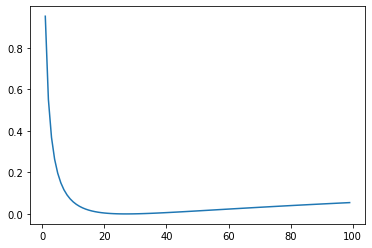

In [26]:
def loss_fn(x):
    d = x + 3 * 1
    predict = tf.constant([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return label_smoothing(tf.log(predict),
                 tf.constant([1]), 5, 0, 0.1)

with tf.Session() as sess:
    out = [loss_fn(x) for x in range(1, 100)]
    out_np = sess.run(out)
#     print(out_np)
    plt.plot(np.arange(1, 100), out_np)

In [27]:
def get_rate(factor, model_size, warmup, step = None):
    "Implement `lrate` above"
    return factor * (model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5)))

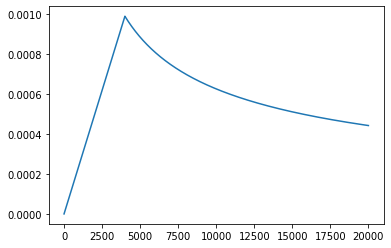

In [28]:

plt.plot(np.arange(1, 20000), [get_rate(1,256, 4000, i) for i in range(1, 20000)])

# A First  Example
> We can begin by trying out a simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols. 

## Synthetic Data

In [29]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = np.constant(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = tf.constant(data)
        tgt = tf.constant(data)
        yield batch(src, tgt, 0)

## Full Model

In [30]:
nbatches = 20

In [82]:
tf.reset_default_graph()
V = 11
d_model = 512
batch_size = 30

src = tf.placeholder(shape=[None, V-1], dtype=tf.int32) #(b, V-1)
tgt = tf.placeholder(shape=[None, V-1], dtype=tf.int32) #(b, V-1)
drop_rate = tf.placeholder(shape=(), dtype=tf.float32) #()
lr = tf.placeholder(shape=(), dtype=tf.float32) #()

bsrc, btrg, bsrc_mask, btrg_mask, btrg_y, bntokens = batch(src, tgt, 0)


src_emb = sequential(bsrc, V, d_model, drop_rate)
trg_emb = sequential(btrg, V, d_model, drop_rate)

enc = encoder(src_emb, bsrc_mask, d_model, drop_rate, 2)
dec = decoder(trg_emb, enc, bsrc_mask, btrg_mask, d_model, drop_rate, N=2)



In [83]:
loss = simple_loss_compute(dec, btrg_y, bntokens, 0, d_model, V, 0)

Tensor("Log:0", shape=(?, 9, 11), dtype=float32)


In [84]:
opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.9, beta2=0.98, epsilon=1e-9)
training_op = opt.minimize(loss)

C:\Anaconda\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [85]:
saver = tf.train.Saver()

# Training

This section describes the training regime for our models.

In [97]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    for epoch in range(10):
        ls_tot = 0
        for i in range(nbatches):
            data = np.random.randint(1, V, size=(batch_size, 10))
            data[:, 0] = 1
            rt = get_rate(1, d_model, 400, step)
            
            feed_dict = {src: data, tgt:data, drop_rate:0.1, lr:rt}
            ls, _, bt = sess.run([loss, training_op, bntokens], feed_dict=feed_dict)
            ls_tot+=ls
            step+=1
            if i%5==0:
                print(ls/bt)
#             break
        print(ls_tot/nbatches)
        ls_tot = 0
#         break
    saver.save(sess, './transformer.ckpt')

0.009255527
0.0091324365
0.008817964
0.008631888
2.401467669010162
0.008537464
0.008275485
0.0071856454
0.0055231657
1.866079068183899
0.0030215147
0.0012271309
0.00032887442
0.0003339599
0.22027557180263102
6.200826e-05
1.676639e-05
1.1751563e-05
5.4378984e-06
0.005786295916186646
6.972396e-06
6.4809706e-06
2.4938677e-06
3.344526e-06
0.009116914062178693
3.25922e-05
1.2578937e-05
1.7473203e-05
8.8016845e-05
0.018741896508436183
6.225374e-05
1.790397e-05
5.885113e-05
4.7567166e-05
0.018746485718293116
8.814938e-05
7.070804e-05
0.00045219844
0.0003264171
0.06989623671397567
6.547619e-05
0.000108248925
0.00024133142
0.00030843276
0.06377495108172297
0.00040812144
0.0012304769
0.00018547518
0.0012903168
0.14835455026477576


# Training

This section describes the training regime for our models.

In [239]:
def greedy_decode(src_inp, max_len=10, start_symbol=1):
    src_test = [0]*max_len
    src_test[0] = 1
    tgt_test = [0]*max_len
    tgt_test[0] = 1
    
    with tf.Session() as sess:
        saver.restore(sess, './transformer.ckpt')
        src_test = src_inp
        for i in range(max_len-1):
#             src_test[i+1] = src_inp[i+1]
            src_temp = np.reshape(np.array(src_test), [-1,max_len])
            tgt_temp = np.reshape(np.array(tgt_test), [-1,max_len])
            rt = 0
            feed_dict = {src: src_temp, tgt:tgt_temp, drop_rate:0, lr:rt}
            prob = tf.get_default_graph().get_tensor_by_name('Log:0')
            out = sess.run(prob, feed_dict=feed_dict)
            out = np.squeeze(out)
            p = np.argmax(out[i,:])
#             print(p)
            tgt_test[i+1] = p
    return tgt_test

In [256]:
a = np.random.randint(1,11, 10)
a[0] = 1

In [258]:
greedy_decode(a)

INFO:tensorflow:Restoring parameters from ./transformer.ckpt


[1, 1, 10, 10, 3, 8, 1, 1, 4, 7]